<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev1/PracticaFinal_TacklingNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import os
id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA
To: /content/nfl-big-data-bowl-2024.zip
100%|██████████| 293M/293M [00:10<00:00, 27.7MB/s]


In [2]:
from zipfile import ZipFile

if not os.path.exists(folder):
	with ZipFile(output, 'r') as zObject:
		zObject.extractall(folder)

In [3]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [ ]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


Dentro de la carpeta nfl-big-data-bowl-2024 se encuentran los csv que utilizaremos, a continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [4]:
dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

In [ ]:
dfs.keys()

dict_keys(['games', 'players', 'plays', 'tackles', 'tracking_week_1', 'tracking_week_2', 'tracking_week_3', 'tracking_week_4', 'tracking_week_5', 'tracking_week_6', 'tracking_week_7', 'tracking_week_8', 'tracking_week_9'])

In [ ]:
df_week1 = dfs['tracking_week_1']

game_ids = df_week1['gameId'].unique()
df_week1_game1 = df_week1[df_week1['gameId']==game_ids[0]]

play_ids = df_week1_game1['playId'].unique()
df_week1_game1_play1 = df_week1_game1[df_week1_game1['playId']==play_ids[0]]

frame_ids = df_week1_game1_play1['frameId'].unique()
df_week1_game1_play1_frame1 = df_week1_game1_play1[df_week1_game1_play1['frameId']==frame_ids[0]]

df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [ ]:
df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)
df_week1_game1_play1_frame1.head(3)

C:\Users\alfre\AppData\Local\Temp\ipykernel_19984\3667134759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)


,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['players'][['position', 'nflId']], on='nflId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT


In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Como ahora sabemos el equipo local en la columna club cambiamos las abreviaturas a valor 0 (visitante) ó 1 (local) ó -1 (football)

In [ ]:
df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]

'LA'

In [ ]:
local = df_week1_game1_play1_frame1['homeTeamAbbr'].unique()[0]
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == 'football', 'club'] = -1
df_week1_game1_play1_frame1.loc[df_week1_game1_play1_frame1['club'] == local, 'club'] = 1
df_week1_game1_play1_frame1.loc[(df_week1_game1_play1_frame1['club'] != -1) & (df_week1_game1_play1_frame1['club'] != 1), 'club'] = 0
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Si ataca el equipo local playDirection = 1, en caso contrario (ataca equipo visitante) playDirection = 0

In [ ]:
df_week1_game1_play1_frame1.loc[:, 'playDirection'] = int(df_week1_game1_play1_frame1['playDirection'].unique()[0] == 'right')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA


Sustituimos el tiempo por el cuarto de juego en el que se encuentran y añadimos columnas con el intento (down) y el número de yardas restantes (yardsToGo)

In [ ]:
df_week1_game1_play1_frame1 = pd.merge(df_week1_game1_play1_frame1, dfs['plays'][['down', 'quarter', 'yardsToGo', 'gameId', 'playId']], on=['gameId', 'playId'], how='left')
df_week1_game1_play1_frame1.drop(columns='time')
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN,G,LA,1,1,10
1,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,1,0,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN,ILB,LA,1,1,10
2,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,1,0,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN,DT,LA,1,1,10


Ordenamos los jugadores por equipo

In [ ]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.sort_values(by='club', ascending=True)
df_week1_game1_play1_frame1.head(3)

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,homeTeamAbbr,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,LA,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,LA,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,LA,1,1,10


Eliminamos la columna de equipo local, obteniendo los datos finales para un frame que utilizaremos

In [ ]:
df_week1_game1_play1_frame1 = df_week1_game1_play1_frame1.drop(columns='homeTeamAbbr')
df_week1_game1_play1_frame1

,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event,position,down,quarter,yardsToGo
22,2022090800,56,NaN,1,2022-09-08 20:24:05.200000,-1,0,85.050003,33.810001,22.209999,11.85,2.07,NaN,NaN,NaN,NaN,1,1,10
20,2022090800,56,53522.0,1,2022-09-08 20:24:05.200000,0,0,91.960000,33.010000,2.400000,2.57,0.24,23.25,117.85,NaN,T,1,1,10
18,2022090800,56,52536.0,1,2022-09-08 20:24:05.200000,0,0,74.350000,7.140000,7.910000,0.79,0.79,269.06,260.37,NaN,WR,1,1,10
17,2022090800,56,48512.0,1,2022-09-08 20:24:05.200000,0,0,90.220000,32.080000,2.770000,2.46,0.28,103.24,115.97,NaN,C,1,1,10
14,2022090800,56,47879.0,1,2022-09-08 20:24:05.200000,0,0,76.540000,32.030000,6.100000,4.49,0.61,155.02,220.71,NaN,TE,1,1,10
13,2022090800,56,47857.0,1,2022-09-08 20:24:05.200000,0,0,88.170000,24.170000,1.940000,0.33,0.19,325.95,238.13,NaN,RB,1,1,10
10,2022090800,56,44985.0,1,2022-09-08 20:24:05.200000,0,0,76.700000,18.390000,4.790000,6.34,0.49,157.83,233.63,NaN,WR,1,1,10
9,2022090800,56,44875.0,1,2022-09-08 20:24:05.200000,0,0,89.420000,25.810000,1.890000,2.47,0.18,242.67,65.25,NaN,T,1,1,10
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,0,0,88.370000,27.270000,1.620000,1.15,0.16,231.74,147.90,NaN,G,1,1,10
4,2022090800,56,42489.0,1,2022-09-08 20:24:05.200000,0,0,80.600000,38.290000,6.230000,0.90,0.62,140.05,189.38,NaN,WR,1,1,10


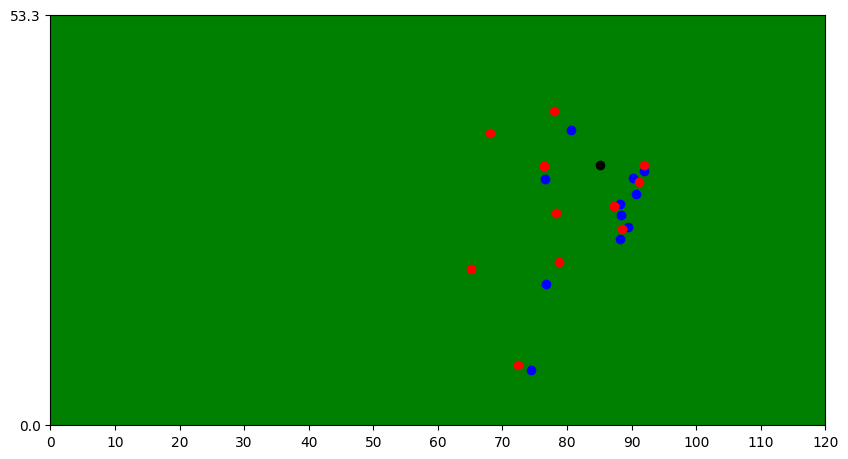

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5.33))

for i, row in df_week1_game1_play1_frame1.iterrows():
    if row['club'] == 0:
        color = 'blue'
    elif row['club'] == 1:
        color = 'red'
    else:
        color = 'black'
    ax.scatter(row['x'], row['y'], marker='o', color=color)
plt.xticks(range(0, 130, 10))
plt.yticks([0, 53.3])
ax.set_facecolor('green')

plt.show()


In [5]:
ds = pd.concat([dfs[f'tracking_week_{i}'] for i in range(1, 10)])
ds.drop(columns=['displayName', 'jerseyNumber', 'event', 'time', 'o', 'dir'], inplace=True)
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13
...,...,...,...,...,...,...,...,...,...,...,...
1150018,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15
1150019,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12
1150020,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09
1150021,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07


In [6]:
import numpy as np
ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')
ds = pd.merge(ds, ds_conteo, on=['gameId', 'playId', 'frameId'], how='left')
ds = ds.loc[ds['Conteo'] != 1]
ds_conteo = ds.groupby(['gameId', 'playId', 'frameId']).size().reset_index(name='Conteo')
print('Limpieza de frames con nº agentes distinto a 23 (22 jugadores + 1 balón)')
print(f'Array con número de agentes por frame encontrados {np.unique(ds_conteo["Conteo"])}')
ds.drop(columns='Conteo', inplace=True)
ds

Array con número de agentes por frame encontrados [ 1 23]
Limpieza de frames con nº agentes distinto a 23 (22 jugadores + 1 balón)
Array con número de agentes por frame encontrados [23]


,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13
...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15
12187394,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12
12187395,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09
12187396,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07


In [7]:
ds['playDirection'] = ds['playDirection'].replace({'left': -1, 'right': 1})
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis
0,2022090800,56,35472.0,1,BUF,-1,88.370000,27.270000,1.62,1.15,0.16
1,2022090800,56,35472.0,2,BUF,-1,88.470000,27.130000,1.67,0.61,0.17
2,2022090800,56,35472.0,3,BUF,-1,88.560000,27.010000,1.57,0.49,0.15
3,2022090800,56,35472.0,4,BUF,-1,88.640000,26.900000,1.44,0.89,0.14
4,2022090800,56,35472.0,5,BUF,-1,88.720000,26.800000,1.29,1.24,0.13
...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,NaN,40,football,1,26.219999,19.680000,1.37,2.58,0.15
12187394,2022110700,3787,NaN,41,football,1,26.320000,19.610001,1.07,2.74,0.12
12187395,2022110700,3787,NaN,42,football,1,26.389999,19.559999,0.80,2.49,0.09
12187396,2022110700,3787,NaN,43,football,1,26.450001,19.520000,0.57,2.38,0.07


In [8]:
ds = pd.merge(ds, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')
ds['local'] = -1
ds.loc[ds['club'] == ds['homeTeamAbbr'], 'local'] = 1
ds.loc[ds['club'] == 'football', 'local'] = 0
ds.drop(columns=['club', 'homeTeamAbbr'], inplace=True)
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,local
0,2022090800,56,35472.0,1,-1,88.370000,27.270000,1.62,1.15,0.16,-1
1,2022090800,56,35472.0,2,-1,88.470000,27.130000,1.67,0.61,0.17,-1
2,2022090800,56,35472.0,3,-1,88.560000,27.010000,1.57,0.49,0.15,-1
3,2022090800,56,35472.0,4,-1,88.640000,26.900000,1.44,0.89,0.14,-1
4,2022090800,56,35472.0,5,-1,88.720000,26.800000,1.29,1.24,0.13,-1
...,...,...,...,...,...,...,...,...,...,...,...
12187212,2022110700,3787,NaN,40,1,26.219999,19.680000,1.37,2.58,0.15,0
12187213,2022110700,3787,NaN,41,1,26.320000,19.610001,1.07,2.74,0.12,0
12187214,2022110700,3787,NaN,42,1,26.389999,19.559999,0.80,2.49,0.09,0
12187215,2022110700,3787,NaN,43,1,26.450001,19.520000,0.57,2.38,0.07,0


In [9]:
ds = pd.merge(ds, dfs['plays'][['ballCarrierId', 'playId', 'gameId']], on=['playId', 'gameId'], how='left')
ds['ballCarrier'] = 0
ds.loc[ds['nflId'] == ds['ballCarrierId'], 'ballCarrier'] = 1
ds.drop(columns='ballCarrierId', inplace=True)
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,local,ballCarrier
0,2022090800,56,35472.0,1,-1,88.370000,27.270000,1.62,1.15,0.16,-1,0
1,2022090800,56,35472.0,2,-1,88.470000,27.130000,1.67,0.61,0.17,-1,0
2,2022090800,56,35472.0,3,-1,88.560000,27.010000,1.57,0.49,0.15,-1,0
3,2022090800,56,35472.0,4,-1,88.640000,26.900000,1.44,0.89,0.14,-1,0
4,2022090800,56,35472.0,5,-1,88.720000,26.800000,1.29,1.24,0.13,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12187212,2022110700,3787,NaN,40,1,26.219999,19.680000,1.37,2.58,0.15,0,0
12187213,2022110700,3787,NaN,41,1,26.320000,19.610001,1.07,2.74,0.12,0,0
12187214,2022110700,3787,NaN,42,1,26.389999,19.559999,0.80,2.49,0.09,0,0
12187215,2022110700,3787,NaN,43,1,26.450001,19.520000,0.57,2.38,0.07,0,0


In [10]:
ds.sort_values(by=['gameId', 'playId', 'frameId', 'local'], ascending=True, inplace=True)
# Como el orden de local es ascendente los 11 jugadores de las primeras 11 filas se corresponden con visitantes
# Haciendo innecesario el uso de la columna local
ds.reset_index(drop=True, inplace=True)
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,local,ballCarrier
0,2022090800,56,35472.0,1,-1,88.37,27.27,1.62,1.15,0.16,-1,0
1,2022090800,56,42392.0,1,-1,88.25,28.74,0.67,1.97,0.07,-1,0
2,2022090800,56,42489.0,1,-1,80.60,38.29,6.23,0.90,0.62,-1,1
3,2022090800,56,44875.0,1,-1,89.42,25.81,1.89,2.47,0.18,-1,0
4,2022090800,56,44985.0,1,-1,76.70,18.39,4.79,6.34,0.49,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12187212,2022110700,3787,52666.0,44,1,25.24,20.96,1.46,1.37,0.15,1,0
12187213,2022110700,3787,52942.0,44,1,20.01,24.78,0.71,0.74,0.07,1,0
12187214,2022110700,3787,53098.0,44,1,31.32,35.89,4.83,2.53,0.49,1,0
12187215,2022110700,3787,54476.0,44,1,29.35,9.76,0.30,1.01,0.04,1,0


In [11]:
import tensorflow as tf
numeric_feature_names = ['playDirection', 'x', 'y', 's', 'a', 'dis']
numeric_features = ds[numeric_feature_names]
numeric_features.head()
snapshots = tf.convert_to_tensor(numeric_features)
snapshots = tf.reshape(snapshots, (-1, 23, 6))

target = 'ballCarrier'
label_features = ds[target]
labels = tf.convert_to_tensor(label_features)
labels = tf.reshape(labels, (-1, 23))
snapshots.shape, labels.shape

(TensorShape([529879, 23, 6]), TensorShape([529879, 23]))

In [12]:
ds_nfl =  tf.data.Dataset.from_tensor_slices((snapshots, labels))
ds_nfl

<_TensorSliceDataset element_spec=(TensorSpec(shape=(23, 6), dtype=tf.float64, name=None), TensorSpec(shape=(23,), dtype=tf.int64, name=None))>

In [31]:
for elem in ds_nfl.take(1):
  print(elem)

(<tf.Tensor: shape=(23, 6), dtype=float64, numpy=
array([[-1.00000000e+00,  8.83700000e+01,  2.72700000e+01,
         1.62000000e+00,  1.15000000e+00,  1.60000000e-01],
       [-1.00000000e+00,  8.82500000e+01,  2.87400000e+01,
         6.70000000e-01,  1.97000000e+00,  7.00000000e-02],
       [-1.00000000e+00,  8.06000000e+01,  3.82900000e+01,
         6.23000000e+00,  9.00000000e-01,  6.20000000e-01],
       [-1.00000000e+00,  8.94200000e+01,  2.58100000e+01,
         1.89000000e+00,  2.47000000e+00,  1.80000000e-01],
       [-1.00000000e+00,  7.67000000e+01,  1.83900000e+01,
         4.79000000e+00,  6.34000000e+00,  4.90000000e-01],
       [-1.00000000e+00,  9.07500000e+01,  3.00100000e+01,
         2.90000000e-01,  1.00000000e+00,  3.00000000e-02],
       [-1.00000000e+00,  8.81700000e+01,  2.41700000e+01,
         1.94000000e+00,  3.30000000e-01,  1.90000000e-01],
       [-1.00000000e+00,  7.65400000e+01,  3.20300000e+01,
         6.10000000e+00,  4.49000000e+00,  6.10000000e-01]

Tomamos datos de test.

In [32]:
num_train = len(ds_nfl)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_nfl.skip(test_size)
ds_test = ds_nfl.take(test_size)

Y datos de validacion

In [33]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_nfl.skip(validation_size)
ds_val = ds_nfl.take(validation_size)

In [47]:
# Supongamos que tienes un conjunto de datos ds_fit y ds_val
# Asegúrate de configurar el tamaño del lote al crear los conjuntos de datos
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Arquitectura de la red

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la red convolucional
model = models.Sequential()

model.add(layers.Input(shape=(23,6)))

# Capa de convolución 1D
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Capa de aplanado para conectar con una capa densa
model.add(layers.Flatten())

# Capa densa
model.add(layers.Dense(128, activation='relu'))

# Capa de salida
model.add(layers.Dense(23, activation='softmax'))  # Suponiendo que estás realizando una tarea de clasificación 23

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen de la arquitectura del modelo
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 21, 64)            1216      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 640)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               82048     
                                                                 
 dense_23 (Dense)            (None, 23)                2967      
                                                                 
Total params: 86231 (336.84 KB)
Trainable params: 86231 (336.84 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [49]:
# Entrenamiento del modelo
history = model.fit(ds_fit, epochs=10, validation_data=ds_val)

Epoch 1/10
3478/3478 [==============================] - 43s 10ms/step - loss: 0.1439 - accuracy: 0.3137 - val_loss: 0.1431 - val_accuracy: 0.3092
Epoch 2/10
3478/3478 [==============================] - 31s 9ms/step - loss: 0.1018 - accuracy: 0.5277 - val_loss: 0.1512 - val_accuracy: 0.3257
Epoch 3/10
3478/3478 [==============================] - 35s 10ms/step - loss: 0.0806 - accuracy: 0.6492 - val_loss: 0.1671 - val_accuracy: 0.3316
Epoch 4/10
3478/3478 [==============================] - 18s 5ms/step - loss: 0.0667 - accuracy: 0.7301 - val_loss: 0.1949 - val_accuracy: 0.3121
Epoch 5/10
3478/3478 [==============================] - 17s 5ms/step - loss: 0.0581 - accuracy: 0.7794 - val_loss: 0.2272 - val_accuracy: 0.2962
Epoch 6/10
3478/3478 [==============================] - 18s 5ms/step - loss: 0.0523 - accuracy: 0.8096 - val_loss: 0.2391 - val_accuracy: 0.2937
Epoch 7/10
3478/3478 [==============================] - 19s 5ms/step - loss: 0.0484 - accuracy: 0.8311 - val_loss: 0.2594 - val_

In [51]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

828/828 [==============================] - 3s 3ms/step - loss: 0.2579 - accuracy: 0.3934
Test accuracy: 0.393404096364975
